In [25]:
%load_ext autoreload
%autoreload 2
%aimport anndata
%aimport os
%aimport torch
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from typing import Dict, Union, List, Tuple
from torch.utils.data import Dataset
# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
import copy
import scvi
from scvi.dataset import CortexDataset, RetinaDataset, CsvDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed
from scvi.dataset.utils import setup_anndata

#STUFF THAT I MESSED AROUND WITH
# from BioDataset import BioDataset
# from constants import X_KEY, BATCH_KEY, LOCAL_L_MEAN_KEY, LOCAL_L_VAR_KEY, LABELS_KEY

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
save_path = "data/"
gene_dataset = CortexDataset(save_path=save_path, total_genes=None)
gene_dataset.subsample_genes(1000, mode="variance")
gene_dataset.make_gene_names_lower()


[2020-06-17 00:13:46,211] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/expression.bin already downloaded
[2020-06-17 00:13:46,212] INFO - scvi.dataset.cortex | Loading Cortex data
[2020-06-17 00:13:55,550] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2020-06-17 00:13:56,841] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-17 00:13:56,843] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-17 00:13:58,778] INFO - scvi.dataset.dataset | Downsampling from 19972 to 1000 genes
[2020-06-17 00:13:58,905] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-17 00:13:58,918] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-17 00:13:58,988] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-17 00:13:58,994] INFO - scvi.dataset.dataset | Downsampled from 3005 to 3005 cells
[2020-06-17 00:13:59,009] INFO - scvi.dataset.dataset | Making gen

In [42]:
adata = gene_dataset.to_anndata()

adata.layers['rawX'] = adata.X
adata.X = adata.X/10

setup_anndata(adata,batch_key='batch_indices', labels_key = 'precise_labels',X_layers_key = 'rawX',  )


[2020-06-17 00:22:11,894] INFO - scvi.dataset.utils | Using data from adata.layers["rawX"]
[2020-06-17 00:22:11,894] INFO - scvi.dataset.utils | Using batches from adata.obs["batch_indices"]
[2020-06-17 00:22:11,896] INFO - scvi.dataset.utils | Using labels from adata.obs["precise_labels"]
[2020-06-17 00:22:11,900] INFO - scvi.dataset.utils | Calculating log mean and log variance per batch
[2020-06-17 00:22:11,910] INFO - scvi.dataset.utils | Successfully registered anndata object containing 3005 cells, 1000 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [19]:
adata.uns['scvi_data_registry']

{'X': ('layers', 'rawX'),
 'batch_indices': ('obs', '_scvi_batch'),
 'local_l_mean': ('obs', '_scvi_local_l_mean'),
 'local_l_var': ('obs', '_scvi_local_l_var'),
 'labels': ('obs', '_scvi_labels')}

In [20]:
adata.obs

,batch_indices,cell_types,precise_labels,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
0,0,interneurons,1,0,0,6.376017,0.445956
1,0,interneurons,1,0,0,6.376017,0.445956
2,0,interneurons,1,0,0,6.376017,0.445956
3,0,interneurons,1,0,0,6.376017,0.445956
4,0,interneurons,1,0,0,6.376017,0.445956
...,...,...,...,...,...,...,...
3000,0,endothelial-mural,9,0,8,6.376017,0.445956
3001,0,endothelial-mural,9,0,8,6.376017,0.445956
3002,0,endothelial-mural,9,0,8,6.376017,0.445956
3003,0,endothelial-mural,9,0,8,6.376017,0.445956


In [22]:
n_epochs = 2
lr = 1e-3
use_cuda = True

#nbatch, ngenes, nproteins
vae = VAE(adata.shape[1], n_batch = adata.uns['scvi_summary_stats']['n_batch'])
trainer = UnsupervisedTrainer(
    vae,
    adata,
    train_size=0.90,
    n_epochs_kl_warmup = 2,
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs = n_epochs)

[2020-06-16 14:16:40,579] WARNING - scvi.dataset.biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-16 14:16:40,615] WARNING - scvi.dataset.biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-16 14:16:40,649] WARNING - scvi.dataset.biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-16 14:16:40,685] WARNING - scvi.dataset.biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-06-16 14:16:42,448] INFO - scvi.inference.inference | KL warmup for 2 epochs



[2020-06-16 14:16:48,891] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [9]:
full = trainer.create_posterior(trainer.model, adata, indices=np.arange(len(gene_dataset)))

full = full.update({"batch_size":32})


In [10]:
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()


In [11]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()


In [12]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



In [13]:
n_samples = 100
M_permutation = 100000

In [14]:
de_res = full.differential_expression_score(
    cell_idx1,
    cell_idx2,
    n_samples=n_samples,
    M_permutation=M_permutation,
)


In [15]:
de_res

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
malat1,1.0,0.0,18.420681,0.053640,0.001975,1147.784180,617.398315,1.000000,1.000000,182.325119,71.251678
gm6654,1.0,0.0,18.420681,0.001719,0.000811,7.589025,7.182108,0.967073,0.941427,1.330467,0.768984
ptn,1.0,0.0,18.420681,0.003109,0.000845,19.885366,6.935037,0.987805,0.872204,3.161307,0.770051
mat2a,1.0,0.0,18.420681,0.001186,0.000712,5.423171,4.882854,0.898780,0.914803,0.895768,0.522960
vmp1,1.0,0.0,18.420681,0.001888,0.000458,9.510976,4.067092,0.975610,0.897764,1.577580,0.444916
...,...,...,...,...,...,...,...,...,...,...,...
sub1,0.0,1.0,-18.420681,0.001081,0.002570,5.663414,34.103302,0.930488,1.000000,0.909549,3.707439
hspa8,0.0,1.0,-18.420681,0.001139,0.002940,7.514634,26.514378,0.934146,0.995740,1.155698,2.769989
npcd,0.0,1.0,-18.420681,0.000315,0.001224,1.110976,9.210862,0.314634,0.906283,0.193483,0.972725
snca,0.0,1.0,-18.420681,0.000601,0.003838,1.757317,31.736954,0.364634,0.998935,0.273074,3.342047


In [16]:
genes_of_interest = ["thy1", "mbp"]
de_res.filter(items=genes_of_interest, axis=0)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
thy1,0.0,1.0,-18.420681,0.000262,0.001282,0.589024,13.569755,0.219512,0.996805,0.089729,1.444312
mbp,1.0,0.0,18.420681,0.008135,0.000766,55.318295,2.787008,0.998780,0.452609,8.840034,0.298456


In [17]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

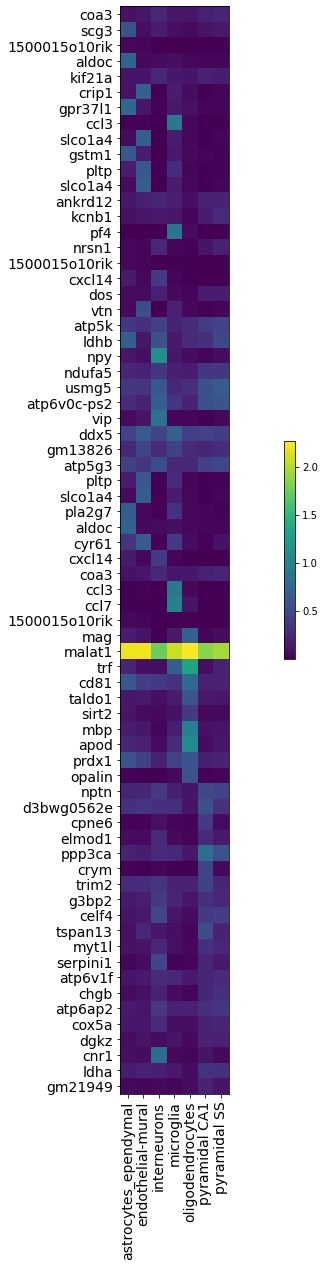

In [19]:
%matplotlib inline
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='viridis', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)
